# Power Outage Data Analysis

**Name(s)**: John Collins

**Website Link**: (your website link)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

In [2]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    precision_score
)

In [3]:
import plotly.io as pio
pio.renderers.default = 'browser'

## Step 1: Introduction

## Step 2: Data Cleaning and Exploratory Data Analysis

In [4]:
# First step. Data cleaning.
# All of data cleaning stuff

df = pd.read_csv('power_outages.csv')
df = df.set_index('OBS')
# Kept only necessary data
df = df[['YEAR','MONTH','U.S._STATE','POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
   'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME',
   'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'TOTAL.CUSTOMERS', 'PC.REALGSP.STATE',
   'POPPCT_URBAN', 'POPDEN_URBAN']]

# Deleted rows with NA's. There were only 9, so it is an insignficant amount of data.
df = df.dropna(subset=['MONTH', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'OUTAGE.START.DATE', 'OUTAGE.START.TIME'])

# Adjusted data to date time objecst and dropped original
df['OUTAGE.START'] = pd.to_datetime(df['OUTAGE.START.DATE'] + ' ' + df['OUTAGE.START.TIME'])
df['OUTAGE.RESTORATION'] = pd.to_datetime(df['OUTAGE.RESTORATION.DATE'] + ' ' + df['OUTAGE.RESTORATION.TIME'])
df = df.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])

#Fixing columns
df.columns = df.columns.str.lower().str.replace('.', '_', regex=False)
df = df.rename(columns={'u_s__state': 'state'})

# Filling in missing outage_duration and outage_restoration
df['outage_duration'] = (df['outage_restoration'] - df['outage_start']).dt.total_seconds() / 60
median_durations = df.groupby(['nerc_region', 'cause_category'])['outage_duration'].transform('median')
df['outage_duration'] = df['outage_duration'].fillna(median_durations)
# If there are still any NaN values, we can fall back to the overall median
overall_median = df['outage_duration'].median()
df['outage_duration'] = df['outage_duration'].fillna(overall_median)
df.isna().sum()
# Now, for the rows where we imputed the duration, let's also update the restoration time
mask = df['outage_restoration'].isna()
df.loc[mask, 'outage_restoration'] = df.loc[mask, 'outage_start'] + pd.to_timedelta(df.loc[mask, 'outage_duration'], unit='m')
# Add a flag to indicate which rows had imputed durations
df['duration_imputed'] = mask

# Let's do the same thing but for customers_efffected
# First, create the flag before filling in values
df['customers_affected_imputed'] = df['customers_affected'].isna()
# Then proceed with filling in the missing values
median_customers = df.groupby(['nerc_region', 'cause_category'])['customers_affected'].transform('median')
df['customers_affected'] = df['customers_affected'].fillna(median_customers)
# If there are remaining missing values we fill in with the overall median
overall_median_customers = df['customers_affected'].median()
df['customers_affected'] = df['customers_affected'].fillna(overall_median_customers)

# Fill in cause category. Fill in missing values with original cause_category values if.
df['cause_detail_missing'] = df['cause_category_detail'].isna()
df['cause_category_detail'] = (df.apply(lambda row: row['cause_category'] 
                                        if pd.isnull(row['cause_category_detail']) else row['cause_category_detail'], axis=1))

In [5]:
# Cleaned data frame
# Example data frame
print(df.head().to_markdown())

|   OBS |   year |   month | state     | postal_code   | nerc_region   | climate_region     |   anomaly_level | climate_category   | cause_category     | cause_category_detail   |   outage_duration |   customers_affected |   total_customers |   pc_realgsp_state |   poppct_urban |   popden_urban | outage_start        | outage_restoration   | duration_imputed   | customers_affected_imputed   | cause_detail_missing   |
|------:|-------:|--------:|:----------|:--------------|:--------------|:-------------------|----------------:|:-------------------|:-------------------|:------------------------|------------------:|---------------------:|------------------:|-------------------:|---------------:|---------------:|:--------------------|:---------------------|:-------------------|:-----------------------------|:-----------------------|
|     1 |   2011 |       7 | Minnesota | MN            | MRO           | East North Central |            -0.3 | normal             | severe weather     | severe

In [6]:
# UNIVARIATE PLOT 1
# Create a Plotly box plot
fig = px.box(
    df, 
    x='cause_category', 
    y='outage_duration', 
    title='Comparison of Outage Durations by Cause', 
    labels={
        'cause_category': 'Cause Category',
        'outage_duration': 'Outage Duration (hours)'
    },
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Update the layout for a clean appearance
fig.update_layout(
    xaxis_title='Cause Category',
    yaxis_title='Outage Duration (hours)',
    title_font_size=16,
    xaxis_tickangle=45,
    xaxis_tickfont=dict(size=12),
    yaxis_tickfont=dict(size=12),
    margin=dict(l=0, r=0, t=50, b=0),
    height=600,
    width=1000
)

# Show the Plotly plot
fig.show()

# Write to HTML
fig.write_html('assets/outage_durations_vs_cause.html', include_plotlyjs='cdn')


In [7]:
# BIVARIATE PLOT 1
fig1 = px.scatter(
    df,
    x='outage_duration',
    y='customers_affected',
    color='cause_category',
    title='Customers Affected vs. Outage Duration',
    labels={
        'outage_duration': 'Outage Duration (minutes)',
        'customers_affected': 'Customers Affected'
    },
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig1.update_traces(marker=dict(size=10, line=dict(width=1, color='black')), opacity=0.7)
fig1.update_layout(
    title_font_size=16,
    xaxis_title='Outage Duration (minutes)',
    yaxis_title='Customers Affected',
    legend_title_text='Cause Category',
    legend=dict(x=1.05, y=1, title_font=dict(size=14), font=dict(size=12)),
    margin=dict(l=0, r=0, t=50, b=0),
    width=1000,
    height=600
)

fig1.show()

fig1.write_html('assets/customers_vs_cause_duration_part1.html', include_plotlyjs='cdn')


In [8]:
# BIVARIATE PLOT 1 PART 2
df_filtered = df[df['cause_category'] == 'intentional attack'].copy()
fig2 = px.scatter(
    df_filtered,
    x='outage_duration',
    y='customers_affected',
    title='Customers Affected vs. Outage Duration (Intentional Attack)',
    labels={
        'outage_duration': 'Outage Duration (minutes)',
        'customers_affected': 'Customers Affected'
    },
    color_discrete_sequence=['orange']  #Orange
)

fig2.update_traces(marker=dict(size=10, line=dict(width=1, color='black')), opacity=0.7)
fig2.update_layout(
    title_font_size=16,
    xaxis_title='Outage Duration (minutes)',
    yaxis_title='Customers Affected',
    margin=dict(l=0, r=0, t=50, b=0),
    width=1000,
    height=600
)

fig2.show()

fig2.write_html('assets/customers_vs_cause_duration_part2.html', include_plotlyjs='cdn')

In [9]:
# HEATMAP

pivot_table = pd.crosstab(df['nerc_region'], df['cause_category'])

# Convert pivot table (melt) for plotly heatmap
pivot_table_melted = pivot_table.reset_index().melt(id_vars='nerc_region', var_name='cause_category', value_name='outage_count')

# plotly heatmap
fig3 = px.density_heatmap(
    pivot_table_melted, 
    x='cause_category', 
    y='nerc_region', 
    z='outage_count', 
    text_auto=True,  # Show the annotations 
    color_continuous_scale='YlOrRd',
    labels={
        'cause_category': 'Cause Category',
        'nerc_region': 'NERC Region',
        'outage_count': 'Number of Outages'
    },
    title='Frequency of Outage Causes by NERC Region'
)

# update style
fig3.update_layout(
    title_font_size=16,
    xaxis_title='Cause Category',
    yaxis_title='NERC Region',
    xaxis_tickangle=45,
    xaxis_tickfont=dict(size=12),
    yaxis_tickfont=dict(size=12),
    coloraxis_colorbar=dict(title='Number of Outages'),
    margin=dict(l=0, r=0, t=50, b=0),
    width=800,
    height=600
)

fig3.show()

fig3.write_html('assets/causes_vs_NERC_region_heat_map.html', include_plotlyjs='cdn')



In [10]:
# ATTACKS PER YEAR

pivot_1 = pd.pivot_table(df, values='outage_duration', index='year', columns='cause_category', aggfunc='count', fill_value=0)
intentional_attacks_by_year = pivot_1['intentional attack']
#print(intentional_attacks_by_year)

markdown_table1 = intentional_attacks_by_year.to_markdown()

# Print the Markdown table
print(markdown_table1)

|   year |   intentional attack |
|-------:|---------------------:|
|   2000 |                    2 |
|   2001 |                    0 |
|   2002 |                    1 |
|   2003 |                    2 |
|   2004 |                    0 |
|   2005 |                    0 |
|   2006 |                    0 |
|   2007 |                    0 |
|   2008 |                    0 |
|   2009 |                    0 |
|   2010 |                    0 |
|   2011 |                  121 |
|   2012 |                   89 |
|   2013 |                   80 |
|   2014 |                   47 |
|   2015 |                   43 |
|   2016 |                   33 |


In [11]:
'''Average Outage Duration and Customers Affected by Cause Category and NERC Region:'''
aggregate_1 = df.groupby(['nerc_region', 'cause_category']).agg({
    'outage_duration': 'mean',
    'customers_affected': 'mean'
}).reset_index()

aggregate_1.sort_values('outage_duration', ascending=False).head(10)

,nerc_region,cause_category,outage_duration,customers_affected
23,RFC,fuel supply emergency,33142.80,0.00
44,TRE,fuel supply emergency,16416.00,56000.00
30,SERC,fuel supply emergency,14805.00,56000.00
...,...,...,...,...
2,ECAR,severe weather,6035.14,166976.21
6,FRCC,public appeal,4320.00,0.00
41,SPP,severe weather,4279.39,173494.11


In [12]:
'''Frequency of Outage Causes by Year:'''
pivot_1 = pd.pivot_table(df, values='outage_duration', index='year', columns='cause_category', aggfunc='count', fill_value=0)
list(pivot_1['intentional attack'])
pivot_1

cause_category,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
year,,,,,,,
2000,2,0,2,0,0,10,5
2001,1,0,0,0,3,1,10
2002,0,0,1,0,0,12,3
...,...,...,...,...,...,...,...
2014,0,13,47,1,5,45,1
2015,0,2,43,9,4,48,13
2016,0,3,33,2,0,12,9


In [13]:
'''Average Outage Duration by Month and Cause Category:'''
aggregate_2 = df.groupby(['month', 'cause_category'])['outage_duration'].mean().unstack()
aggregate_2

cause_category,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
month,,,,,,,
1.0,618.67,31828.50,286.84,NaN,2681.25,4327.45,819.13
2.0,479.75,12941.11,356.10,359.50,1041.40,3078.62,448.45
3.0,19866.50,17703.60,889.67,51.67,945.50,3321.77,219.86
...,...,...,...,...,...,...,...
10.0,NaN,NaN,214.06,13.33,351.00,6289.57,298.75
11.0,503.00,758.00,237.33,129.00,NaN,3035.30,528.33
12.0,838.25,15059.00,598.98,436.00,6293.50,4097.18,500.78


In [14]:
'''Percentage of Outages by Cause Category for Each NERC Region:'''
cause_by_region = df.groupby(['nerc_region', 'cause_category']).size().unstack(fill_value=0)
cause_by_region_pct = cause_by_region.div(cause_by_region.sum(axis=1), axis=0) * 100
cause_by_region_pct

cause_category,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
nerc_region,,,,,,,
ECAR,5.88,0.00,2.94,0.00,0.00,82.35,8.82
FRCC,9.30,0.00,4.65,0.00,6.98,60.47,18.60
"FRCC, SERC",0.00,0.00,0.00,0.00,0.00,0.00,100.00
...,...,...,...,...,...,...,...
SPP,1.52,1.52,12.12,3.03,24.24,54.55,3.03
TRE,1.80,4.50,8.11,0.00,14.41,55.86,15.32
WECC,6.87,4.43,41.91,7.76,2.66,24.17,12.20


## Step 3: Assessment of Missingness

In [15]:
original_df = pd.read_csv('power_outages.csv')
original_df
original_df = original_df[['YEAR','MONTH','U.S._STATE','POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
   'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME',
   'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'TOTAL.CUSTOMERS', 'PC.REALGSP.STATE',
   'POPPCT_URBAN', 'POPDEN_URBAN']]

In [16]:
missingness = original_df.isnull().sum() / len(original_df) * 100
#print(missingness[missingness > 0].sort_values(ascending=False))
original_df['customers_affected_missing'] = original_df['CUSTOMERS.AFFECTED'].isnull().astype(int)
original_df['customers_affected_missing']

0       0
1       1
2       0
       ..
1531    1
1532    1
1533    0
Name: customers_affected_missing, Length: 1534, dtype: int64

In [17]:
# permutation test
def permutation_test(df, col1, col2, n_permutations=1000):
    observed_diff = df[df[col2] == 0][col1].mean() - df[df[col2] == 1][col1].mean()
    
    diffs = []
    for _ in range(n_permutations):
        shuffled = df[col2].sample(frac=1).reset_index(drop=True)
        diff = df[shuffled == 0][col1].mean() - df[shuffled == 1][col1].mean()
        diffs.append(diff)
    
    p_value = (np.abs(np.array(diffs)) >= np.abs(observed_diff)).mean()
    return p_value

In [18]:
# Test dependency 
p_value_duration = permutation_test(original_df, 'OUTAGE.DURATION', 'customers_affected_missing')
print(f"P-value for outage_duration: {p_value_duration}")



P-value for outage_duration: 0.021


In [19]:
# Test dependency on 'year'
p_value_year = permutation_test(original_df, 'YEAR', 'customers_affected_missing')
print(f"P-value for year: {p_value_year}")



P-value for year: 0.0


In [20]:
######
#Permutation test 1 visualization

def permutation_test_with_distribution(df, col1, col2, n_permutations=1000):
    observed_diff = df[df[col2] == 0][col1].mean() - df[df[col2] == 1][col1].mean()
    
    diffs = []
    for _ in range(n_permutations):
        shuffled = df[col2].sample(frac=1).reset_index(drop=True)
        diff = df[shuffled == 0][col1].mean() - df[shuffled == 1][col1].mean()
        diffs.append(diff)
    
    p_value = (np.abs(np.array(diffs)) >= np.abs(observed_diff)).mean()
    return observed_diff, diffs, p_value

observed_diff, diffs, p_value = permutation_test_with_distribution(original_df, 'OUTAGE.DURATION', 'customers_affected_missing')

fig = go.Figure()

fig.add_trace(go.Histogram(x=diffs, name='Permutation Distribution', opacity=0.7))

fig.add_trace(go.Scatter(x=[observed_diff, observed_diff], y=[0, 30], 
                         mode='lines', name='Observed Difference',
                         line=dict(color='red', width=2, dash='dash')))

fig.update_layout(
    title='Outage Duration vs Customers Affected Missingness',
    xaxis_title='Difference in Means',
    yaxis_title='Frequency',
    title_font_size=18,  # Increase title font size
    margin=dict(l=80, r=80, t=100, b=80),  # Increase margins
    annotations=[
        dict(x=observed_diff, y=25, xref='x', yref='y',
             text=f'observed Diff: {observed_diff:.2f}', showarrow=True,
             font=dict(color='red'), arrowhead=2, ax=50, ay=-40),
        dict(x=0.9, y=0.95, xref='paper', yref='paper',
             text=f'p-value: {p_value:.4f}', showarrow=False,
             font=dict(size=14))
    ],
    autosize=True  
)


fig.show()
fig.write_html('assets/permutation_test_outage_duration_vs_missingness_customers_affected.html', include_plotlyjs='cdn')


In [21]:
# Permutation test 2import numpy as np
def permutation_test_with_distribution(df, col1, col2, n_permutations=1000):
    observed_diff = df[df[col2] == 0][col1].mean() - df[df[col2] == 1][col1].mean()
    
    diffs = []
    for _ in range(n_permutations):
        shuffled = df[col2].sample(frac=1).reset_index(drop=True)
        diff = df[shuffled == 0][col1].mean() - df[shuffled == 1][col1].mean()
        diffs.append(diff)
    
    p_value = (np.abs(np.array(diffs)) >= np.abs(observed_diff)).mean()
    return observed_diff, diffs, p_value

observed_diff, diffs, p_value = permutation_test_with_distribution(original_df, 'YEAR', 'customers_affected_missing')

fig = go.Figure()

# histogram 
fig.add_trace(go.Histogram(x=diffs, name='Permutation Distribution', opacity=0.7))

fig.add_trace(go.Scatter(x=[observed_diff, observed_diff], y=[0, 30], 
                         mode='lines', name='Observed Difference',
                         line=dict(color='red', width=2, dash='dash')))

# layout
fig.update_layout(
    title='Year vs Customers Affected Missingness',
    xaxis_title='Difference in Mean Year',
    yaxis_title='Frequency',
    title_font_size=18,
    margin=dict(l=80, r=80, t=100, b=80),
    annotations=[
        dict(x=observed_diff, y=25, xref='x', yref='y',
             text=f'Observed Difference: {observed_diff:.2f}', showarrow=True,
             font=dict(color='red'), arrowhead=2, ax=50, ay=-40),
        dict(x=0.9, y=0.95, xref='paper', yref='paper',
             text=f'p-value: {p_value:.4f}', showarrow=False,
             font=dict(size=14))
    ],
    autosize=True
)

fig.show()

print(f"Observed diff- mean year: {observed_diff:.2f}")
print(f"P-value: {p_value:.4f}")

Observed diff- mean year: -1.85
P-value: 0.0000


In [22]:
# MY BOX PLOT
fig = px.box(
    original_df, 
    x='customers_affected_missing', 
    y='OUTAGE.DURATION',
    title='Outage Duration vs Missingness of Customers Affected',
    labels={
        'customers_affected_missing': 'Customers Affected Missing',
        'OUTAGE.DURATION': 'Outage Duration (minutes)'
    },
    color='customers_affected_missing',  
    color_discrete_sequence=['#FF6347', '#4682B4'],  
    width=800,
    height=600
)

fig.update_traces(
    boxpoints='outliers',  
    opacity=0.9,           
    line=dict(width=2),    
    marker=dict(size=6, color='black')  
)

fig.update_layout(
    yaxis_range=[0, 20000],
    title_font_size=16,
    xaxis_title='Customers Affected Missing',
    yaxis_title='Outage Duration (minutes)',
    xaxis_tickfont=dict(size=12),
    yaxis_tickfont=dict(size=12),
    showlegend=False,  
)

fig.show()
fig.write_html('assets/boxplot_outage_duration_vs_customers_affected.html', include_plotlyjs='cdn')


## Step 4: Hypothesis Testing

In [23]:
fig = go.Figure()

# Add histogram of permutation distribution
fig.add_trace(
    go.Histogram(x=diffs, nbinsx=100, name="Permutation Distribution", marker_color="skyblue")
)

# Add vertical line for observed difference
fig.add_trace(
    go.Scatter(x=[observed_diff, observed_diff], 
               y=[0, np.max(np.histogram(diffs, bins=100)[0])],
               mode="lines", 
               name=f"Observed Difference: {observed_diff:.2f}",
               line=dict(color="red", width=2, dash="dash"))
)

# Calculate the range for x-axis
max_abs_diff = max(abs(np.min(diffs)), abs(np.max(diffs)), abs(observed_diff))
x_range = [-max_abs_diff * 1.1, max_abs_diff * 1.1]

# Update layout
fig.update_layout(
    title_text="Permutation Test: Outage Duration (Severe Weather vs Intentional Attacks)",
    xaxis_title="Difference in Mean Outage Duration (minutes)",
    yaxis_title="Frequency",
    showlegend=True,
    height=600,
    width=1000
)

# Update x-axis
fig.update_xaxes(range=x_range, zeroline=True, zerolinecolor='black', zerolinewidth=1)

# Add annotation for observed difference
fig.add_annotation(
    x=observed_diff,
    y=np.max(np.histogram(diffs, bins=100)[0]) * 0.9,
    text=f"Observed Diff: {observed_diff:.2f}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40,
    bgcolor="yellow",
    bordercolor="black",
    borderwidth=1,
    opacity=0.8
)

fig.show()
fig.write_html('assets/hypothesis_test_graph.html', include_plotlyjs='cdn')

## Step 5: Framing a Prediction Problem

"Predict whether a power outage is caused by an intentional attack based on its characteristics and regional factors."

## Step 6: Baseline Model

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       220
           1       0.72      1.00      0.84        84

    accuracy                           0.89       304
   macro avg       0.86      0.93      0.88       304
weighted avg       0.92      0.89      0.90       304

F1 Score: 0.835820895522388


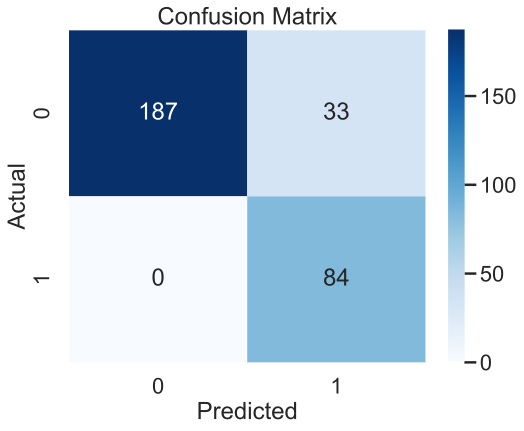


Top 10 Most Important Features:
               feature  importance
1   customers_affected        9.75
12    nerc_region_WECC        1.29
4     nerc_region_FRCC        1.09
..                 ...         ...
19           month_8.0        0.88
18           month_7.0        0.76
10     nerc_region_SPP        0.75

[10 rows x 2 columns]


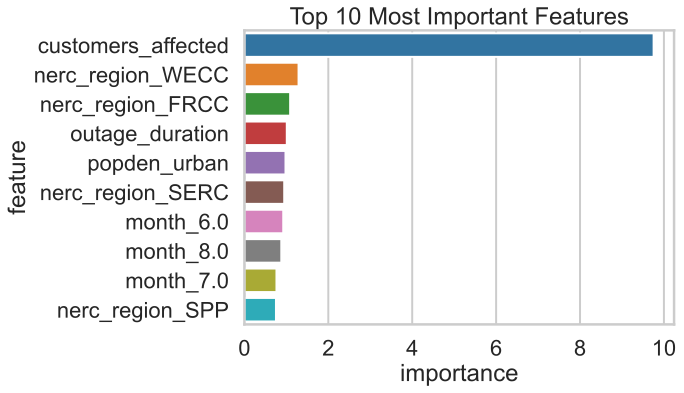


Class Balance:
0    0.72
1    0.28
Name: is_intentional_attack, dtype: float64


In [24]:
df['is_intentional_attack'] = (df['cause_category'] == 'intentional attack').astype(int)

features = ['nerc_region', 'outage_duration', 'customers_affected', 'month', 
            'pc_realgsp_state', 'popden_urban']
X = df[features]
y = df['is_intentional_attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numeric_features = ['outage_duration', 'customers_affected', 'pc_realgsp_state', 'popden_urban']
categorical_features = ['nerc_region', 'month']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

feature_names = (numeric_features + 
                 model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

coefficients = model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': abs(coefficients)})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

class_balance = y.value_counts(normalize=True)
print("\nClass Balance:")
print(class_balance)



## Step 7: Final Model

In [25]:
df['is_intentional_attack'] = (df['cause_category'] == 'intentional attack').astype(int)

df['season'] = pd.to_datetime(df['month'], format='%m').dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 
                                                                      4: 'Spring', 5: 'Spring', 6: 'Summer',
                                                                      7: 'Summer', 8: 'Summer', 9: 'Fall', 
                                                                      10: 'Fall', 11: 'Fall', 12: 'Winter'})

features = ['nerc_region', 'outage_duration', 'customers_affected', 'season', 
            'pc_realgsp_state', 'popden_urban']

X = df[features]
y = df['is_intentional_attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# preprocessor
numeric_features = ['outage_duration', 'customers_affected', 'pc_realgsp_state', 'popden_urban']
categorical_features = ['nerc_region', 'season']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['customers_affected', 'pc_realgsp_state', 'popden_urban']),
        ('dur', QuantileTransformer(n_quantiles=100, output_distribution='normal'), ['outage_duration']),
        ('cat', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), categorical_features)
    ])

# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# hyperparameters 
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30]
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# best model
best_model = grid_search.best_estimator_

# predictions
y_pred = best_model.predict(X_test)

# Evaluate
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred)}")

# Compare 
baseline_f1 = 0.84  # Replace with your actual baseline F1 score
print(f"\n\nimprovement over baseline: {f1_score(y_test, y_pred) - baseline_f1:.4f}")

Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       220
           1       0.94      0.92      0.93        84

    accuracy                           0.96       304
   macro avg       0.95      0.95      0.95       304
weighted avg       0.96      0.96      0.96       304

F1 Score: 0.9277108433734941


improvement over baseline: 0.0877


In [26]:
# feature names 
feature_names = (
    numeric_features +
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features).tolist()
)

# feature importances
importances = best_model.named_steps['classifier'].feature_importances_

# dataframe of feature importances
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n\nTop 10 Feature Importances:")
print(feature_importances.head(10))



Top 10 Feature Importances:
               feature  importance
0      outage_duration    5.51e-01
3         popden_urban    2.05e-01
1   customers_affected    8.48e-02
..                 ...         ...
11     nerc_region_TRE    8.86e-03
10     nerc_region_SPP    7.83e-03
7     nerc_region_NPCC    7.22e-03

[10 rows x 2 columns]


## Step 8: Fairness Analysis

In [28]:
# binary column for WECC
X_test['is_WECC'] = (X_test['nerc_region'] == 'WECC').astype(int)

# predictions
y_pred = best_model.predict(X_test)

#calculate precision 
def get_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=1)

# observed difference in precision
wecc_precision = get_precision(y_test[X_test['is_WECC'] == 1], y_pred[X_test['is_WECC'] == 1])
non_wecc_precision = get_precision(y_test[X_test['is_WECC'] == 0], y_pred[X_test['is_WECC'] == 0])
observed_diff = wecc_precision - non_wecc_precision

# Permutation test
n_permutations = 1000
diffs = []
for _ in range(n_permutations):
    permuted_wecc = np.random.permutation(X_test['is_WECC'])
    permuted_wecc_precision = get_precision(y_test[permuted_wecc == 1], y_pred[permuted_wecc == 1])
    permuted_non_wecc_precision = get_precision(y_test[permuted_wecc == 0], y_pred[permuted_wecc == 0])
    diffs.append(permuted_wecc_precision - permuted_non_wecc_precision)

# Calculate p-value
p_value = np.mean(np.abs(diffs) >= np.abs(observed_diff))

print(f"WECC Precision: {wecc_precision:.4f}")
print(f"Non-WECC Precision: {non_wecc_precision:.4f}")
print(f"Observed difference: {observed_diff:.4f}")
print(f"P-value: {p_value:.4f}")

# histogram 
fig = go.Figure()

# histogram of permutation differences
fig.add_trace(go.Histogram(
    x=diffs, 
    nbinsx=30,  # Match bins size to original
    marker=dict(color='skyblue', line=dict(color='black', width=1)), 
    opacity=0.75
))

# add vertical lines
fig.add_trace(go.Scatter(
    x=[observed_diff, observed_diff], 
    y=[0, 50],  # adjust y-values 
    mode="lines", 
    name=f"Observed Difference: {observed_diff:.4f}",
    line=dict(color="red", dash="dash")
))

fig.add_trace(go.Scatter(
    x=[-observed_diff, -observed_diff], 
    y=[0, 50], 
    mode="lines", 
    line=dict(color="red", dash="dash"),
    showlegend=False
))

# layout
fig.update_layout(
    title='Distribution of Precision Differences in Permutation Test',
    xaxis_title='Difference in Precision (WECC - Non-WECC)',
    yaxis_title='Frequency',
    width=800,
    height=600,
    showlegend=True
)

# plot
fig.show()
fig.write_html('assets/fairness.html', include_plotlyjs='cdn')


WECC Precision: 0.9688
Non-WECC Precision: 0.9200
Observed difference: 0.0487
P-value: 0.3720
